# Dataset Loading

In this section, we load the raw RNA-seq count matrix from GEO (GSE68719) and prepare it for preprocessing.

In [32]:
import pandas as pd
import numpy as np

data=pd.read_csv("GSE68719_raw_counts.tsv" , sep="\t")
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (39376, 74)


,GeneID,GSM1679648,GSM1679649,GSM1679650,GSM1679651,GSM1679652,GSM1679653,GSM1679654,GSM1679655,GSM1679656,...,GSM1679711,GSM1679712,GSM1679713,GSM1679714,GSM1679715,GSM1679716,GSM1679717,GSM1679718,GSM1679719,GSM1679720
0,100287102,27,2,4,18,7,4,15,9,9,...,6,19,16,15,10,52,25,9,11,11
1,653635,2620,929,956,2679,1053,1152,1870,1648,1378,...,444,1649,1472,2077,1394,2302,2301,1856,1848,1496
2,102466751,113,53,64,148,58,76,47,99,65,...,19,105,47,74,37,72,91,97,92,85
3,107985730,6,3,5,6,4,5,2,7,4,...,1,4,6,1,5,3,1,6,3,2
4,100302278,1,1,1,0,0,2,1,2,1,...,0,5,1,1,3,2,3,3,1,0


# Set first column as index (gene names):
 This sets the gene name column as the index of the dataframe.
 How RNA-seq file looks BEFORE this step:
- First column = gene names

- Other columns = samples

- Values = counts

But pandas treats all columns as numeric features, including GeneID.

That is bad for ML.
If we skip this part:

- "GeneID" becomes a feature column

- It contains text (gene names)

- ML models cannot train with text

- Feature selection will break

- Scaling will crash
### but After setting index:
- Gene names are row labels only

- All columns are numeric

- Clean for ML

In [33]:

data = data.set_index(data.columns[0])

data.head()


,GSM1679648,GSM1679649,GSM1679650,GSM1679651,GSM1679652,GSM1679653,GSM1679654,GSM1679655,GSM1679656,GSM1679657,...,GSM1679711,GSM1679712,GSM1679713,GSM1679714,GSM1679715,GSM1679716,GSM1679717,GSM1679718,GSM1679719,GSM1679720
GeneID,,,,,,,,,,,,,,,,,,,,,
100287102,27,2,4,18,7,4,15,9,9,9,...,6,19,16,15,10,52,25,9,11,11
653635,2620,929,956,2679,1053,1152,1870,1648,1378,2284,...,444,1649,1472,2077,1394,2302,2301,1856,1848,1496
102466751,113,53,64,148,58,76,47,99,65,62,...,19,105,47,74,37,72,91,97,92,85
107985730,6,3,5,6,4,5,2,7,4,7,...,1,4,6,1,5,3,1,6,3,2
100302278,1,1,1,0,0,2,1,2,1,1,...,0,5,1,1,3,2,3,3,1,0


# Extract Labels from Series Matrix:
Now we need to determine:

Which samples are PD?

Which samples are Control?

Raw count file usually has GSM accession IDs as columns.
To label them, we need metadata from: "GSE68719_series_matrix.txt"


In [34]:
import gzip

path = "GSE68719_series_matrix.txt"   # OR "GSE68719_series_matrix.txt.gz"

def open_maybe_gz(path):
    # if it's gz, read via gzip; otherwise normal open
    if path.endswith(".gz"):
        return gzip.open(path, "rt", encoding="utf-8", errors="ignore")
    else:
        return open(path, "r", encoding="utf-8", errors="ignore")

sample_titles = []

with open_maybe_gz(path) as f:
    for line in f:
        line = line.lstrip("\ufeff")  # remove BOM if present
        if "!Sample_title" in line:   # (not only startswith)
            parts = line.strip().split("\t")
            sample_titles = parts[1:]
            break

print("Found titles:", len(sample_titles))
print("Example titles:", sample_titles[:5])


Found titles: 73
Example titles: ['"C_0002 [reanalysis of GSM1580869]"', '"C_0003 [reanalysis of GSM1580870]"', '"C_0004 [reanalysis of GSM1580871]"', '"C_0005 [reanalysis of GSM1580872]"', '"C_0006 [reanalysis of GSM1580873]"']


# Build labels (PD=1, Control=0)

In [35]:
labels = []
for t in sample_titles:
    t = t.strip().strip('"')
    if t.startswith("P_"):
        labels.append(1)  # Parkinson
    elif t.startswith("C_"):
        labels.append(0)  # Control

print("Number of labels:", len(labels))
print("Class counts:\n", {0: labels.count(0), 1: labels.count(1)})


Number of labels: 73
Class counts:
 {0: 44, 1: 29}


In [36]:
X = data.T   # samples as rows
y = labels

print("X shape:", X.shape)
print("y length:", len(y))


X shape: (73, 39376)
y length: 73


# normalize RNA-seq counts
Raw RNA-seq counts are not directly comparable across samples because:

- Sequencing depth differs: some samples have more total reads, so their counts are larger even if biology is the same.

- Counts are highly skewed: a few genes have very large values, many genes are near zero. ML models can get dominated by these large-scale genes.

- Variance grows with the mean (heteroscedasticity): many models work better when features have more stable variance.

If you skip normalization:

- Models may learn “library size / depth” instead of disease signal.

- Feature selection methods can pick genes just because they have huge counts.

- Training becomes unstable; metrics can look misleading and generalization worsens.

A common simple pipeline for ML on counts is:

Library-size normalization (CPM)

log1p transform (reduces skew)

Standard scaling (mean 0, std 1) 

In [37]:
from sklearn.preprocessing import StandardScaler

# Make sure X is numeric
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

# 1) CPM normalization (Counts Per Million)
library_size = X.sum(axis=1)  # total counts per sample
X_cpm = X.div(library_size, axis=0) * 1e6

# 2) log transform to reduce skew (log(1 + CPM))
X_log = np.log1p(X_cpm)

# 3) Standardize features (good for SVM/DNN and fair feature selection)
scaler = StandardScaler()
X_norm = pd.DataFrame(
    scaler.fit_transform(X_log),
    index=X_log.index,
    columns=X_log.columns
)

print("X original:", X.shape)
print("X normalized:", X_norm.shape)

# quick sanity checks
print("Any NaN in X_norm?", X_norm.isna().any().any())
print("Mean (approx):", float(X_norm.values.mean()))
print("Std  (approx):", float(X_norm.values.std()))


X original: (73, 39376)
X normalized: (73, 39376)
Any NaN in X_norm? False
Mean (approx): 1.3169194310566528e-18
Std  (approx): 0.9759657486945678


## Train–Test Split and Mean-Difference Feature Extraction

Before applying feature selection, the dataset is divided into training and testing sets.  
This ensures that feature selection is performed only on training data and prevents data leakage.

The first feature extraction method is based on the difference in mean gene expression between Parkinson’پs disease (PD) and control samples.  
Genes showing the largest difference between the two groups are considered more informative for classification.


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keeps PD/control balanced
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (58, 39376)
Test shape: (15, 39376)


### 1. Mean Difference Feature Selection

This method selects genes based on the absolute difference in mean expression between PD and control groups in the training set.

Steps:
1. Compute the mean expression of each gene in PD samples.
2. Compute the mean expression of each gene in control samples.
3. Calculate the absolute difference between the two means.
4. Rank genes by this difference.
5. Select the top genes as informative features.


In [59]:
from sklearn.model_selection import train_test_split

# Make sure y is a NumPy array (important for boolean masking)
y = np.array(labels, dtype=int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Separate PD and Control samples in TRAIN set (use .loc for row filtering)
pd_samples = X_train.loc[y_train == 1]
control_samples = X_train.loc[y_train == 0]

# Mean difference per gene (TRAIN only)
mean_diff = (pd_samples.mean(axis=0) - control_samples.mean(axis=0)).abs()

gene_scores = mean_diff.sort_values(ascending=False)
print("Top 10 genes by mean difference:")
display(gene_scores.head(10))


Top 10 genes by mean difference:


GeneID
6539      1.447282
5351      1.368273
1104      1.363829
147912    1.338513
140876    1.338445
6520      1.310914
5986      1.310245
79724     1.309127
26061     1.300600
2057      1.299261
dtype: float64

The top genes with the highest mean expression difference between PD and control samples were selected as informative features.  
These genes are expected to contribute most to distinguishing between the two classes.

The dataset was then reduced to include only the selected genes, forming the input for subsequent machine learning models.


In [69]:
TOP_N = 100
top_genes = gene_scores.index[:TOP_N]

X_train_sel = X_train[top_genes]
X_test_sel  = X_test[top_genes]

print("Selected genes:", len(top_genes))
print("Train:", X_train_sel.shape, " Test:", X_test_sel.shape)


Selected genes: 100
Train: (58, 100)  Test: (15, 100)


### 2. Variance-Based Feature Selection

Variance-based feature selection identifies genes that exhibit high variability across samples.

The underlying assumption is that genes with very low variance remain almost constant across all individuals and therefore provide little discriminative power for classification tasks. In contrast, genes with higher variance are more likely to capture biological differences between Parkinson’s disease (PD) and control groups.

Why do we perform this method?

- RNA-seq datasets are high-dimensional (thousands of genes).
- Many genes show minimal variation and contribute noise.
- Removing low-variance genes improves model stability.
- It reduces dimensionality before training machine learning models.

Importantly, variance is computed using only the training data to prevent data leakage.


In [67]:
# Step 1: Compute variance per gene (TRAIN ONLY)
gene_variance = X_train.var(axis=0)

# Step 2: Rank genes by variance
variance_ranked = gene_variance.sort_values(ascending=False)

# Step 3: Select top N genes
TOP_N = 100
top_var_genes = variance_ranked.index[:TOP_N]

# Step 4: Reduce dataset
X_train_var = X_train[top_var_genes]
X_test_var  = X_test[top_var_genes]

print("Variance-based feature selection completed.")
print("Train shape:", X_train_var.shape)
print("Test shape:", X_test_var.shape)

Variance-based feature selection completed.
Train shape: (58, 100)
Test shape: (15, 100)


In [68]:
top_variance_genes_df = pd.DataFrame({
    "Gene": top_var_genes,
    "Variance": variance_ranked.iloc[:TOP_N].values
})

top_variance_genes_df.head(10)


,Gene,Variance
0,109616973,1.276102
1,100847064,1.276102
2,105372547,1.276102
3,100113404,1.276102
4,100302202,1.276102
5,105369891,1.276102
6,442891,1.276102
7,105370343,1.276102
8,100302220,1.276102
9,23540,1.276102


### 3.Genetic Algorithm
A Genetic Algorithm (GA) is a population-based optimization method inspired by natural evolution.
In feature selection, each “individual” (chromosome) represents a subset of genes (features). GA searches for a good subset by repeating:

- Selection: keep better subsets (higher fitness)

- Crossover: combine two subsets to create new ones

- Mutation: randomly flip some genes to explore new solutions

Why do this for RNA-seq?

- RNA-seq is high-dimensional (tens of thousands of genes) while the number of samples is small.

- Exhaustive search is impossible.

- GA can explore the space of gene subsets and often finds good feature sets that improve classification.

Important for correctness: GA must be fitted only on the training set to avoid data leakage.

In [70]:
import random
import math
import matplotlib.pyplot as plt

class GA:
    def __init__(self, human_number=100, gene_number=50, generation_num=100, random_state=42):
        self.human_number = human_number
        self.gene_number = gene_number
        self.generation_num = generation_num
        self.random_state = random_state
        random.seed(random_state)
        np.random.seed(random_state)

        # these will be set when fitting
        self.row = None
        self.col = None
        self.selected_idx_ = None
        self.selected_genes_ = None

    def initialization(self):
        human = np.zeros((self.human_number, self.col), dtype=np.int8)
        for j in range(self.human_number):
            createNum = self.createNumber()
            human[j, createNum] = 1
        return human

    def createNumber(self):
        # unique indices for selected genes
        return random.sample(range(self.col), self.gene_number)

    def score(self, human, rawData_std, rawData_np):
        """
        Fitness term based on average absolute correlation among selected genes.
        (Same idea as your original code, but avoids repeated DataFrame creation.)
        """
        avg = np.zeros(human.shape[0], dtype=float)

        for i in range(human.shape[0]):
            ones = np.where(human[i] == 1)[0]
            # safety
            if len(ones) != self.gene_number:
                continue

            score_sum = 0.0
            # pairwise correlation approx via covariance/std
            for a in range(self.gene_number - 1):
                idx = ones[a]
                x = rawData_np[:, idx]
                x_std = rawData_std[idx] + 1e-12

                for b in range(a + 1, self.gene_number):
                    idx2 = ones[b]
                    y = rawData_np[:, idx2]
                    y_std = rawData_std[idx2] + 1e-12

                    score_cov = np.cov(x, y, ddof=1)[0, 1]
                    p_x_y = abs(score_cov / (x_std * y_std))
                    score_sum += p_x_y

            avg[i] = score_sum / (self.gene_number * (self.gene_number - 1))
        return avg

    def cal(self, X0, X1):
        # same idea as your original X_C calculation
        m0 = X0.mean(axis=0).mean()
        m1 = X1.mean(axis=0).mean()
        s0 = X0.std(axis=0).mean()
        s1 = X1.std(axis=0).mean()

        X_C = abs((m0 - m1) / (s0 + s1 + 1e-12))
        X_C = X_C ** -1
        return X_C

    def seperatezerotoone(self, y_np, X_np, human):
        # Proper split using masks (fixes the original nested loops issue)
        X1 = X_np[y_np == 1]  # PD
        X0 = X_np[y_np == 0]  # Control

        X_C = self.cal(X0, X1)
        rawData_std = X_np.std(axis=0)
        avg = self.score(human, rawData_std, X_np)
        return avg, X_C, rawData_std

    def rank(self, avg, X_C):
        final_p_value = np.zeros(len(avg), dtype=float)
        for i in range(len(avg)):
            final_p_value[i] = (X_C * self.gene_number) / math.sqrt(
                self.gene_number + self.gene_number * (self.gene_number - 1) * avg[i] + 1e-12
            )
        rank = final_p_value.argsort()[::-1]
        return rank, final_p_value

    def oneDetector(self, baby):
        ones = np.where(baby == 1)[0]
        if len(ones) < self.gene_number:
            zeros = np.where(baby == 0)[0]
            add = np.random.choice(zeros, size=self.gene_number - len(ones), replace=False)
            baby[add] = 1
        elif len(ones) > self.gene_number:
            drop = np.random.choice(ones, size=len(ones) - self.gene_number, replace=False)
            baby[drop] = 0
        return baby

    def drawGA(self, value):
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.plot(value)
        plt.show()

    def evolve(self, human, rawData_std, X_C, rawData_np):
        new_human = human.copy()
        threshold_GA = []
        human_range = self.human_number

        for p in range(self.generation_num - 1):
            # create children
            for j in range(int(self.human_number / 2)):
                rand_num = random.randint(0, self.col - 1)

                mom = new_human[2 * j]
                dad = new_human[2 * j + 1]

                baby1 = np.concatenate((mom[rand_num:], dad[:rand_num]), axis=None)
                baby2 = np.concatenate((mom[:rand_num], dad[rand_num:]), axis=None)

                baby1 = self.oneDetector(baby1).reshape(1, -1)
                baby2 = self.oneDetector(baby2).reshape(1, -1)

                new_human = np.concatenate((new_human, baby1, baby2), axis=0)

                # mutation (simple)
                if random.random() < 0.1:
                    b = baby1.flatten()
                    ones = np.where(b == 1)[0]
                    zeros = np.where(b == 0)[0]
                    if len(ones) > 0 and len(zeros) > 0:
                        b[np.random.choice(ones, 1)] = 0
                        b[np.random.choice(zeros, 1)] = 1
                    new_human[-2] = self.oneDetector(b).reshape(1, -1)

            avg = self.score(new_human, rawData_std, rawData_np)
            rank, final_p_value = self.rank(avg, X_C)

            new_human = new_human[rank][:human_range]
            threshold_GA.append(final_p_value.max())

        self.drawGA(threshold_GA)
        return new_human

    def fit(self, X_train, y_train):
        """
        X_train: DataFrame (samples x genes)
        y_train: array-like (0/1)
        """
        y_np = np.asarray(y_train, dtype=int)
        X_np = X_train.to_numpy(dtype=float)

        self.row, self.col = X_np.shape

        human = self.initialization()
        avg, X_C, rawData_std = self.seperatezerotoone(y_np, X_np, human)
        rank, _ = self.rank(avg, X_C)
        human = human[rank]

        new_human = self.evolve(human, rawData_std, X_C, X_np)

        best = new_human[0]
        self.selected_idx_ = np.where(best == 1)[0]
        self.selected_genes_ = list(X_train.columns[self.selected_idx_])
        return self

    def transform(self, X):
        if self.selected_genes_ is None:
            raise ValueError("GA not fitted yet. Call fit() first.")
        return X[self.selected_genes_]

    def fit_transform(self, X_train, y_train):
        self.fit(X_train, y_train)
        return self.transform(X_train)


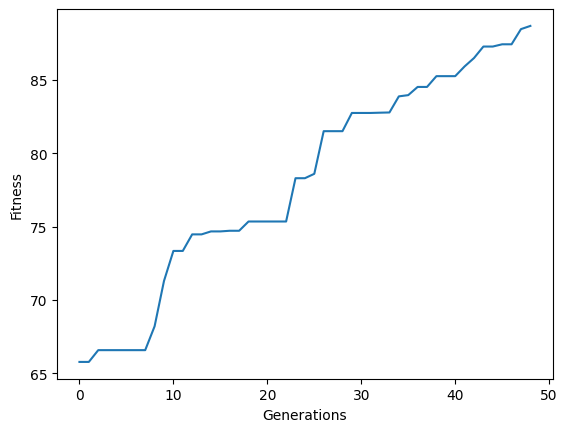

Selected genes (GA) = 50
Top genes (GA): [441873, 79570, 105371442, 6704, 26097, 102466202, 28929, 28893, 105373545, 285194]
Train shape: (58, 50)  Test shape: (15, 50)


In [71]:
# GA feature selection (fit ONLY on training data)
ga = GA(human_number=100, gene_number=50, generation_num=50, random_state=42) 
X_train_ga = ga.fit_transform(X_train, y_train)
X_test_ga  = ga.transform(X_test)

print("Selected genes (GA) =", len(ga.selected_genes_))
print("Top genes (GA):", ga.selected_genes_[:10])
print("Train shape:", X_train_ga.shape, " Test shape:", X_test_ga.shape)


### Pre-filter
Genetic Algorithms become computationally expensive when the number of features is very large (e.g., ~39,000 genes).
GA evaluates many candidate feature subsets across many generations; the larger the search space, the slower it becomes.

A pre-filter reduces the feature space before running GA, typically by keeping only genes that are more likely to be informative. A common and effective pre-filter is variance filtering:

- Genes with very low variance are nearly constant across samples and usually carry little discriminative information.

- Removing them reduces noise, improves numerical stability, and dramatically speeds up GA.

- Most importantly, the pre-filter must be computed using training data only to avoid data leakage.

This produces a smaller candidate set (e.g., top 2,000–5,000 genes), and GA then searches for the best subset inside that reduced set.

In [73]:
TOP_M = 100

train_var = X_train.var(axis=0)

prefilter_genes = train_var.sort_values(ascending=False).index[:TOP_M]

# 3) reduce train and test using the same gene list
X_train_pf = X_train[prefilter_genes]
X_test_pf  = X_test[prefilter_genes]

print("Pre-filtered shapes:")
print("X_train_pf:", X_train_pf.shape)
print("X_test_pf :", X_test_pf.shape)


Pre-filtered shapes:
X_train_pf: (58, 100)
X_test_pf : (15, 100)


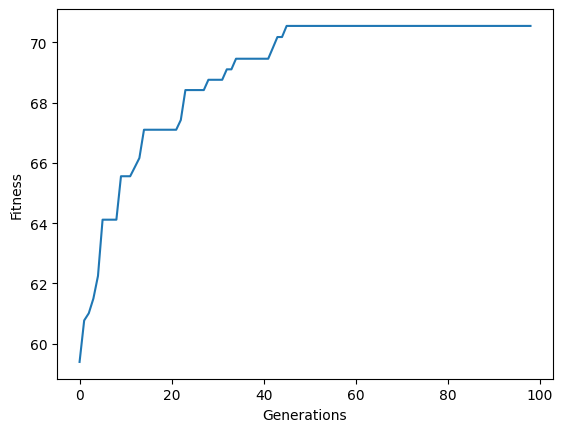

GA + Prefilter selected genes: 50
Top GA genes: [109616973, 100847064, 100113404, 105379306, 100302217, 90070, 102465855, 100616386, 101928389, 100996338]
Train shape: (58, 50)
Test shape: (15, 50)


In [74]:
# ===== GA on pre-filtered data =====
ga_pf = GA(human_number=100, gene_number=50, generation_num=100, random_state=42)

X_train_ga_pf = ga_pf.fit_transform(X_train_pf, y_train)
X_test_ga_pf  = ga_pf.transform(X_test_pf)

print("GA + Prefilter selected genes:", len(ga_pf.selected_genes_))
print("Top GA genes:", ga_pf.selected_genes_[:10])
print("Train shape:", X_train_ga_pf.shape)
print("Test shape:", X_test_ga_pf.shape)


In [75]:
# save selected genes from GA + prefilter
ga_prefilter_genes = ga_pf.selected_genes_

print("Saved", len(ga_prefilter_genes), "GA prefilter genes")

Saved 50 GA prefilter genes


### Information Gain (IG) Feature Selection

Information Gain (IG) measures how much knowing the value of a gene reduces uncertainty about the class label (PD vs Control).
Genes with higher information gain are more informative for classification.

In practice, IG for continuous features is often estimated using mutual information.
To avoid data leakage, IG scores are computed using only the training set, then the same selected genes are applied to the test set.


In [77]:
from sklearn.feature_selection import mutual_info_classif

TOP_N_IG = 100
Xtr = X_train.values
ytr = np.array(y_train, dtype=int)

# Compute IG scores (mutual information) for each gene
ig_scores = mutual_info_classif(Xtr, ytr, random_state=42)

ig_series = pd.Series(ig_scores, index=X_train.columns).sort_values(ascending=False)

# Select top genes
top_ig_genes = ig_series.index[:TOP_N_IG]

# Reduce train/test sets
X_train_ig = X_train[top_ig_genes]
X_test_ig  = X_test[top_ig_genes]

print("IG feature selection completed.")
print("Train shape:", X_train_ig.shape)
print("Test shape :", X_test_ig.shape)

# Show top genes
display(pd.DataFrame({"Gene": top_ig_genes[:10], "IG_score": ig_series.iloc[:10].values}))


IG feature selection completed.
Train shape: (58, 100)
Test shape : (15, 100)


,Gene,IG_score
0,65220,0.378322
1,6189,0.375505
2,10129,0.360164
3,2796,0.348102
4,102466911,0.345804
5,107984010,0.345291
6,144097,0.339801
7,7556,0.339661
8,6539,0.335130
9,90624,0.334334


### Wolf Search Algorithm (WSA) Feature Selection

The Wolf Search Algorithm (WSA) is a nature-inspired metaheuristic that searches for an informative subset of genes.
Each candidate solution (a “wolf”) represents a set of selected genes. The algorithm iteratively improves solutions by balancing:

- exploitation: moving toward the current best solution,
- exploration: random movements to avoid local optima.

Because RNA-seq data is extremely high-dimensional, we first apply a variance-based pre-filter on the training set to reduce the search space.
WSA then selects a fixed number of genes from this reduced pool.

To prevent data leakage, WSA is fitted using training data only, and the selected genes are applied to the test set.


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def wolf_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    top_m: int = 100, 
    k: int = 500,   
    n_wolves: int = 20,
    n_iter: int = 25,
    step_toward_best: float = 0.35,
    random_jump: float = 0.10,
    random_state: int = 42
):
    """
    Returns:
      selected_genes: list of selected gene names (length k)
      fitness_history: list of best fitness values per iteration
    """
    rng = np.random.default_rng(random_state)

    # --- 1) Pre-filter by variance on TRAIN ONLY ---
    variances = X_train.var(axis=0).sort_values(ascending=False)
    pool_genes = variances.index[:top_m]
    X_pool = X_train[pool_genes]

    # --- 2) Internal train/validation split (still within TRAIN) ---
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_pool, y_train, test_size=0.25, random_state=random_state, stratify=y_train
    )

    # Fitness model (fast + strong baseline)
    clf = SVC(kernel="linear", random_state=random_state)

    def fitness(wolf_scores: np.ndarray) -> float:
        # select top-k genes for this wolf
        idx = np.argsort(wolf_scores)[-k:]
        genes = X_pool.columns[idx]
        clf.fit(X_tr[genes], y_tr)
        pred = clf.predict(X_val[genes])
        return accuracy_score(y_val, pred)

    # --- 3) Initialize wolves (continuous scores for each gene in pool) ---
    n_genes = X_pool.shape[1]
    wolves = rng.random((n_wolves, n_genes))  # each row is a wolf
    fitness_vals = np.array([fitness(wolves[i]) for i in range(n_wolves)])

    best_idx = np.argmax(fitness_vals)
    best_wolf = wolves[best_idx].copy()
    best_fit = float(fitness_vals[best_idx])
    history = [best_fit]

    # --- 4) Iterate ---
    for _ in range(n_iter):
        for i in range(n_wolves):
            w = wolves[i].copy()

            # move toward best (exploitation)
            w = w + step_toward_best * (best_wolf - w)

            # random exploration jump
            if rng.random() < 0.5:
                w = w + random_jump * rng.normal(0, 1, size=n_genes)

            # keep in bounds [0, 1]
            w = np.clip(w, 0.0, 1.0)

            # evaluate
            f = fitness(w)

            # accept if improved
            if f >= fitness_vals[i]:
                wolves[i] = w
                fitness_vals[i] = f

                # update global best
                if f > best_fit:
                    best_fit = float(f)
                    best_wolf = w.copy()

        history.append(best_fit)

    # final selected genes from best wolf
    selected_idx = np.argsort(best_wolf)[-k:]
    selected_genes = list(X_pool.columns[selected_idx])

    return selected_genes, history


# ===== Run WSA (Wolf) on your training set =====
# IMPORTANT: y_train should be numpy array
y_train_np = np.array(y_train, dtype=int)

TOP_M_WOLF = 5000
TOP_K_WOLF = 500  # keep same TOP_N as MeanDiff/Variance/IG for fair comparison

top_wolf_genes, wolf_history = wolf_feature_selection(
    X_train, y_train_np,
    top_m=TOP_M_WOLF,
    k=TOP_K_WOLF,
    n_wolves=20,
    n_iter=25,
    random_state=42
)

X_train_wolf = X_train[top_wolf_genes]
X_test_wolf  = X_test[top_wolf_genes]

print("Wolf selected genes:", len(top_wolf_genes))
print("Top Wolf genes (first 10):", top_wolf_genes[:10])
print("Train shape:", X_train_wolf.shape, " Test shape:", X_test_wolf.shape)


Wolf selected genes: 500
Top Wolf genes (first 10): [105376602, 9731, 100422887, 105371536, 28576, 112268025, 23231, 105375396, 107985094, 869]
Train shape: (58, 500)  Test shape: (15, 500)


# Classification Models and Evaluation (Accuracy)

In this section, we evaluate multiple machine learning classifiers on the selected gene subsets produced by different feature selection methods.

We follow the models used in the reference paper:
- Decision Tree (DT)
- Support Vector Machine (SVM)
- Deep Neural Network (DNN)
- XGBoost

Additionally, we include **Logistic Regression** as a strong and stable baseline for high-dimensional biomedical data.

To ensure fair comparison, each classifier is trained on the **training set** and evaluated on the **held-out test set** using **accuracy**.


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    HAS_XGB = False

def evaluate_models_accuracy(Xtr, Xte, ytr, yte, random_state=42):
    """
    Train each model on (Xtr, ytr) and return test accuracy on (Xte, yte).
    """
    models = {
        "DT": DecisionTreeClassifier(random_state=random_state),
        "SVM_linear": SVC(kernel="linear", random_state=random_state),
        # Simple DNN-like model (MLP). Works well as a compact neural baseline in small datasets.
        "DNN_MLP": MLPClassifier(hidden_layer_sizes=(128, 64),
                                 max_iter=800,
                                 random_state=random_state)
    }

    if HAS_XGB:
        models["XGBoost"] = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=random_state,
            eval_metric="logloss"
        )
    else:
        models["XGBoost_like"] = HistGradientBoostingClassifier(random_state=random_state)

    # Strong linear baseline
    models["LogReg"] = LogisticRegression(max_iter=3000, solver="liblinear", random_state=random_state)

    out = {}
    for name, clf in models.items():
        clf.fit(Xtr, ytr)
        pred = clf.predict(Xte)
        out[name] = accuracy_score(yte, pred)

    return out


# Accuracy Comparison Across Feature Selection Methods

Here, we evaluate the classifiers on three feature selection methods implemented so far:

1. Mean Difference (top genes with the largest PD vs Control mean difference)
2. Variance-based selection (top genes with highest variance across samples)
3. Genetic Algorithm (GA) feature selection

For each method, we train all classifiers using the selected gene subset and compute test accuracy.
The results are stored in a table for easy comparison and visualization.


In [80]:
results_acc = {}

# Method 1: Mean Difference
results_acc["MeanDiff"] = evaluate_models_accuracy(X_train_sel, X_test_sel, y_train, y_test)

# Method 2: Variance
results_acc["Variance"] = evaluate_models_accuracy(X_train_var, X_test_var, y_train, y_test)

# Method 3: GA
results_acc["GA"] = evaluate_models_accuracy(X_train_ga, X_test_ga, y_train, y_test)

#Method 4: IG
results_acc["IG"] = evaluate_models_accuracy(X_train_ig, X_test_ig, y_train, y_test)

#Method 5: WSA
results_acc["Wolf"] = evaluate_models_accuracy(X_train_wolf, X_test_wolf, y_train, y_test)

acc_table = pd.DataFrame(results_acc).T
acc_table


,DT,SVM_linear,DNN_MLP,XGBoost_like,LogReg
MeanDiff,0.933333,0.933333,0.933333,0.800000,0.866667
Variance,0.600000,0.600000,0.600000,0.600000,0.600000
GA,0.666667,0.600000,0.466667,0.733333,0.600000
IG,0.866667,0.866667,0.933333,0.866667,0.866667
Wolf,0.800000,0.666667,0.600000,0.666667,0.600000


# Visualization: Accuracy Comparison Plot

To visually compare feature selection methods, we plot the accuracy results.
Each bar corresponds to a classifier, and each group corresponds to a feature selection method.

This provides an intuitive view of how different gene selection strategies affect model performance.


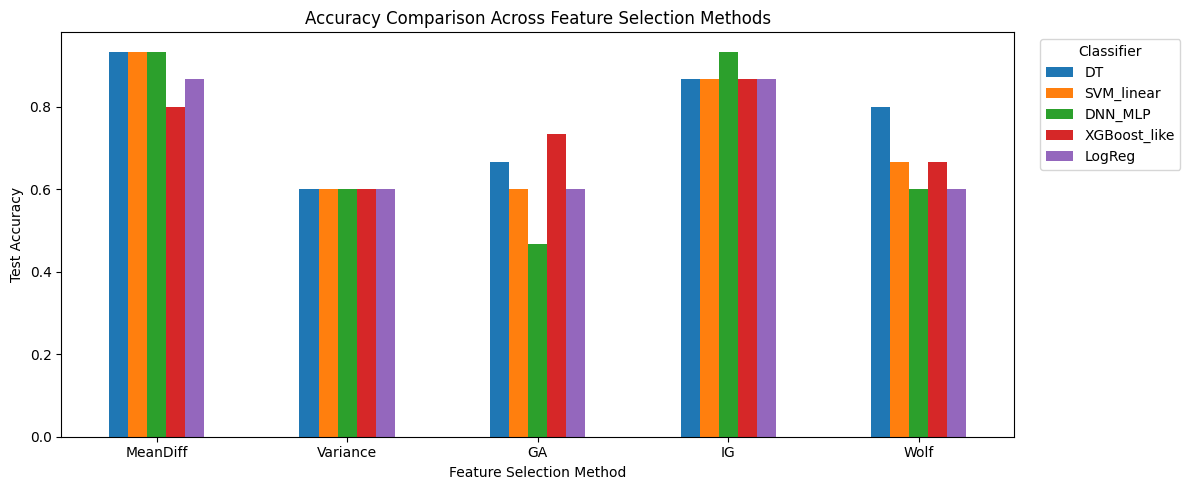

In [81]:
ax = acc_table.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Feature Selection Method")
ax.set_ylabel("Test Accuracy")
ax.set_title("Accuracy Comparison Across Feature Selection Methods")
plt.xticks(rotation=0)
plt.legend(title="Classifier", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
